# Adult Data Set

The model should predict whether income exceeds \$50K/yr based on census data.

* Supervised learning problem
* Classification task (binary classification)
* The performance measurement is the PR curve because the positive class is rare (>50K)


## 1. Imports

In [607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelBinarizer
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.linear_model    import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes     import BernoulliNB
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import plot_precision_recall_curve, precision_recall_curve, confusion_matrix

## 2. Getting the data

In [128]:
dowload_root = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/'
train_path = 'adult.data'
test_path = 'adult.test'
header = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status',
         'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
         'hours-per-week', 'native-country', 'target']
train = pd.read_csv(dowload_root + train_path, names=header)
test = pd.read_csv(dowload_root + test_path, names=header)

In [129]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [130]:
train['target'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [131]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [132]:
test['target'].unique()

array([nan, ' <=50K.', ' >50K.'], dtype=object)

In [133]:
test.dropna(axis=0, inplace=True)

In [134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16281 entries, 1 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16281 non-null  object 
 1   workclass       16281 non-null  object 
 2   fnlwgt          16281 non-null  float64
 3   education       16281 non-null  object 
 4   education-num   16281 non-null  float64
 5   marital-status  16281 non-null  object 
 6   occupation      16281 non-null  object 
 7   relationship    16281 non-null  object 
 8   race            16281 non-null  object 
 9   sex             16281 non-null  object 
 10  capital-gain    16281 non-null  float64
 11  capital-loss    16281 non-null  float64
 12  hours-per-week  16281 non-null  float64
 13  native-country  16281 non-null  object 
 14  target          16281 non-null  object 
dtypes: float64(5), object(10)
memory usage: 2.0+ MB


In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## 3. Exploring and Analysing the data (EDA)

In [213]:
train_eda = train.copy()

In [214]:
train_eda['target'] = train_eda['target'].apply(lambda x: 1 if x == ' >50K' else 0) 

In [215]:
train_eda['target'].nunique()

2

/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>,
        <AxesSubplot:title={'center':'education-num'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

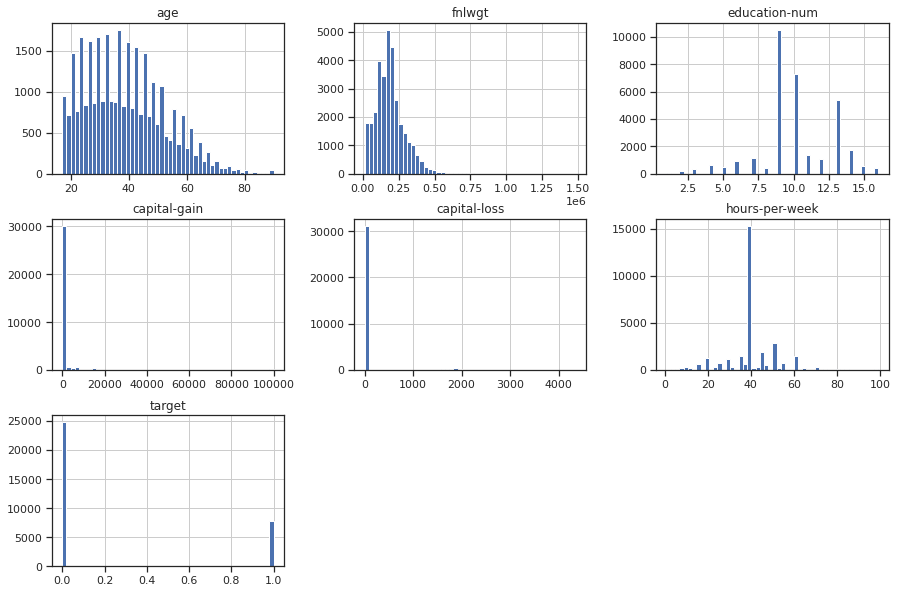

In [216]:
train_eda.hist(figsize=(15, 10), bins=50)

Distributions are non-normal and the scale are very different. Capital-loss is an absolute value. age distribution has a strange pattern 

In [217]:
corr = train_eda.corr()
corr.sort_values(by=['target'], ascending=False)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
target,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463


fnlwgt doesn't have a high correlation with any attribute

<AxesSubplot:>

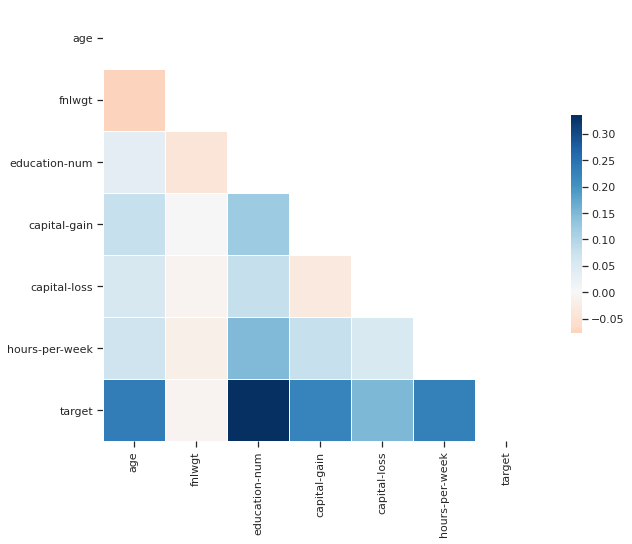

In [218]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=plt.get_cmap('RdBu'), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

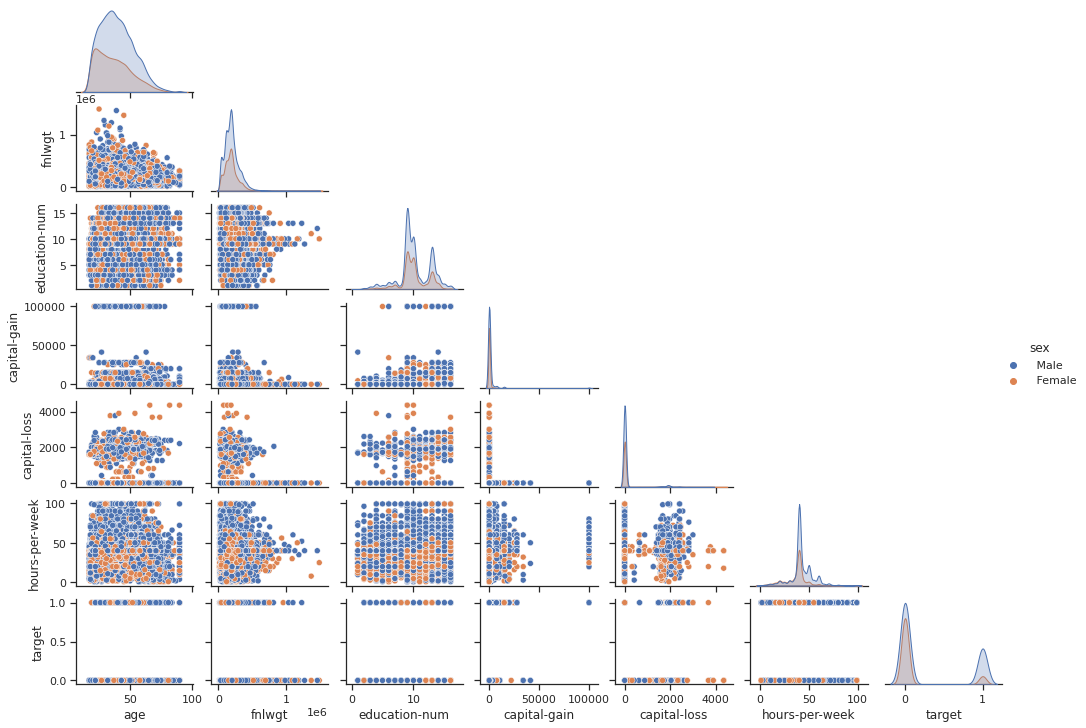

In [219]:
g = sns.pairplot(train_eda, hue='sex', corner=True)
g.fig.set_size_inches(15, 10)

men are old have bigger capital gain work more and earn more

Capital gain and capital loss are capped

### 3.1. Attributes combinations

In [220]:
train_eda['capital_var'] = train_eda['capital-gain'] - train_eda['capital-loss']
train_eda['capital-loss'] = - train_eda['capital-loss']

In [221]:
train_eda.corr().sort_values(by=['target'], ascending=False)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,capital_var
target,0.234037,-0.009463,0.335154,0.223329,-0.150526,0.229689,1.000000,0.214428
education-num,0.036527,-0.043195,1.000000,0.122630,-0.079923,0.148123,0.335154,0.117891
age,1.000000,-0.076646,0.036527,0.077674,-0.057775,0.068756,0.234037,0.074284
hours-per-week,0.068756,-0.018768,0.148123,0.078409,-0.054256,1.000000,0.229689,0.075207
capital-gain,0.077674,0.000432,0.122630,1.000000,0.031615,0.078409,0.223329,0.998521
capital_var,0.074284,0.000988,0.117891,0.998521,0.085902,0.075207,0.214428,1.000000
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,0.010252,-0.018768,-0.009463,0.000988
capital-loss,-0.057775,0.010252,-0.079923,0.031615,1.000000,-0.054256,-0.150526,0.085902


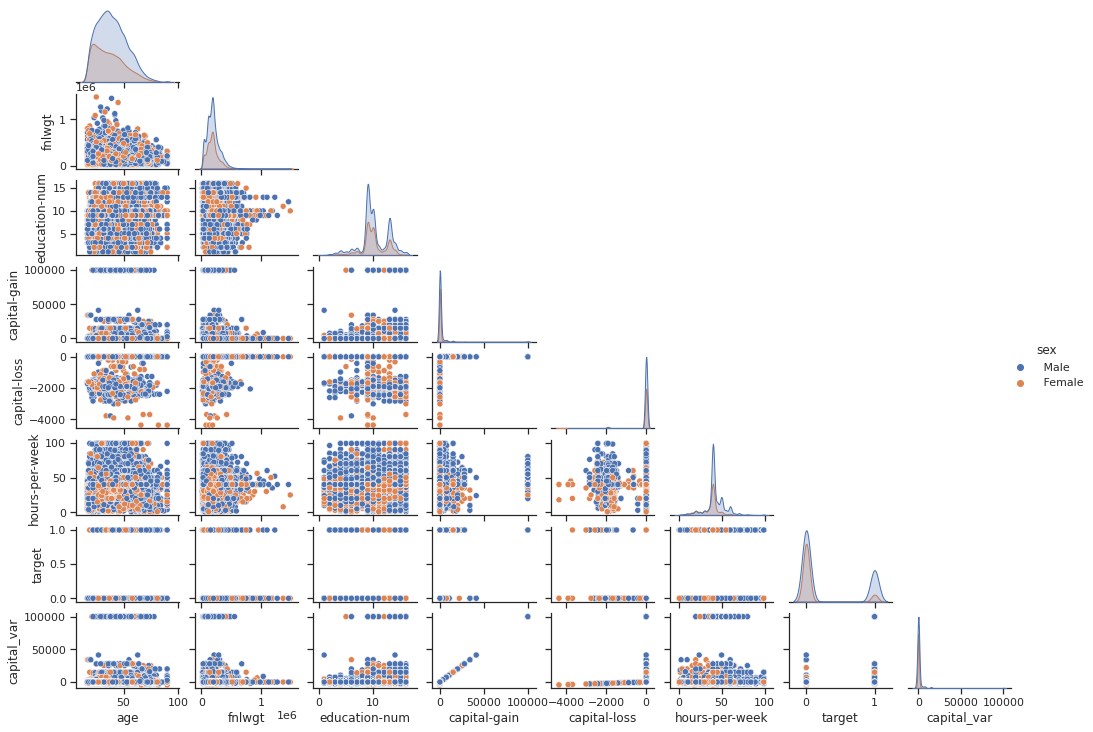

In [222]:
g = sns.pairplot(train_eda, hue='sex', corner=True)
g.fig.set_size_inches(15, 10)

### 3.2. Categorical Attributes

In [223]:
cat_mask = [train_eda[col].dtype == 'object' for col in train_eda.columns]

In [224]:
train_cat = train_eda.loc[:,cat_mask]

In [225]:
train_cat.nunique()

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native-country    42
dtype: int64

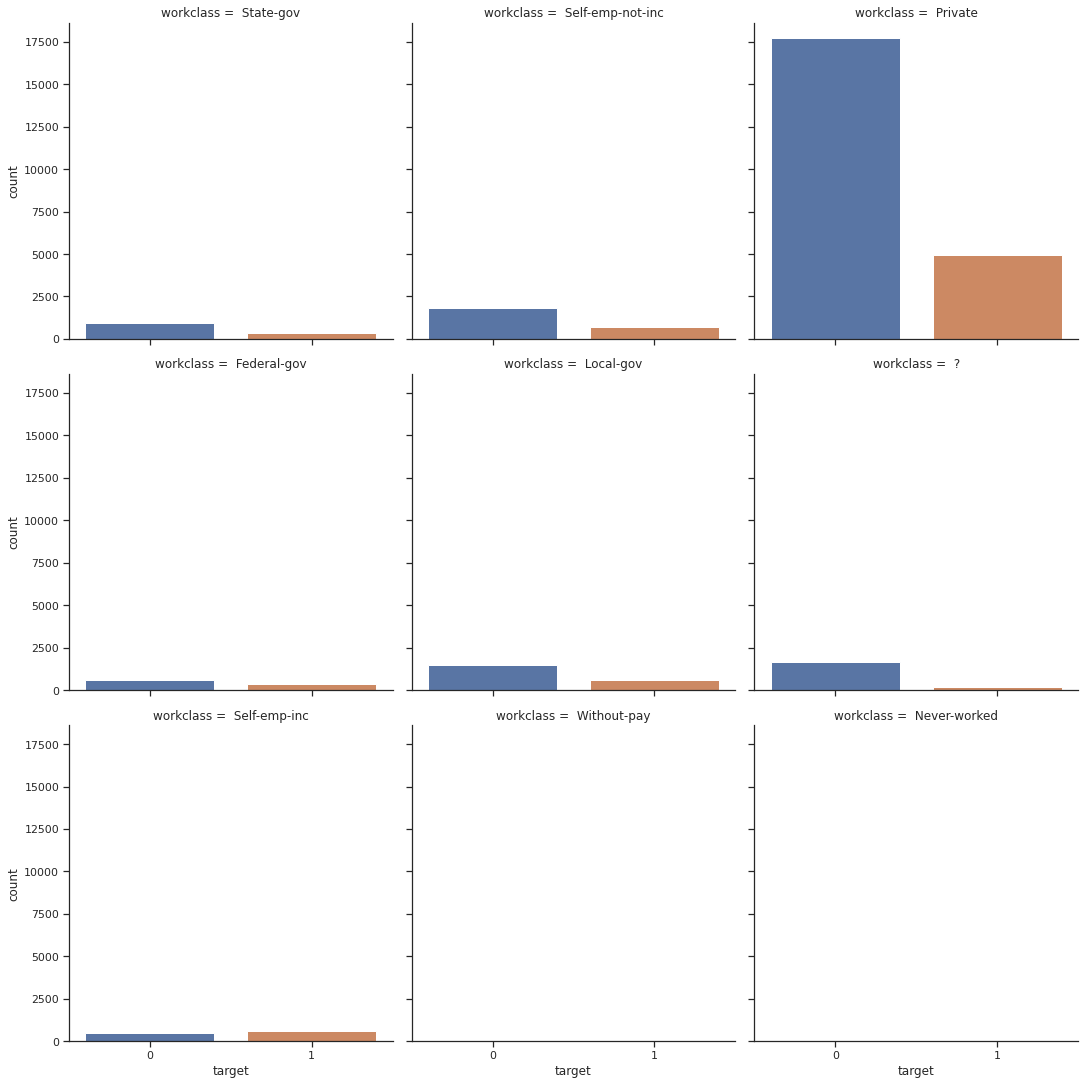

In [226]:
sns.catplot(x='target', col='workclass',
           data=train_eda, kind='count', col_wrap=3)

In [227]:
train_eda['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [228]:
train_eda.loc[train_eda['workclass'] == ' ?']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,capital_var
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1,0
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0,0
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,0,0
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,0,0
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,0,34095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,1,0
32531,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0,0
32539,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,1,0
32541,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,0,0


In [229]:
pd.crosstab(train_eda['target'], train_eda['workclass'], normalize='columns')

workclass,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
target,,,,,,,,,
0,0.895969,0.613542,0.705208,1.0,0.781327,0.442652,0.715073,0.728043,1.0
1,0.104031,0.386458,0.294792,0.0,0.218673,0.557348,0.284927,0.271957,0.0


In [230]:
cat_dict = {' State-gov':'Non-fed-gov', 
            ' Local-gov': 'Non-fed-gov', 
            ' ?': 'Other', 
            ' Without-pay': 'Unemployed', 
            ' Never-worked': 'Unemployed'}

train_eda['workclass_new'] = train_eda['workclass'].apply(lambda x: cat_dict[x] if x in cat_dict.keys() else x)

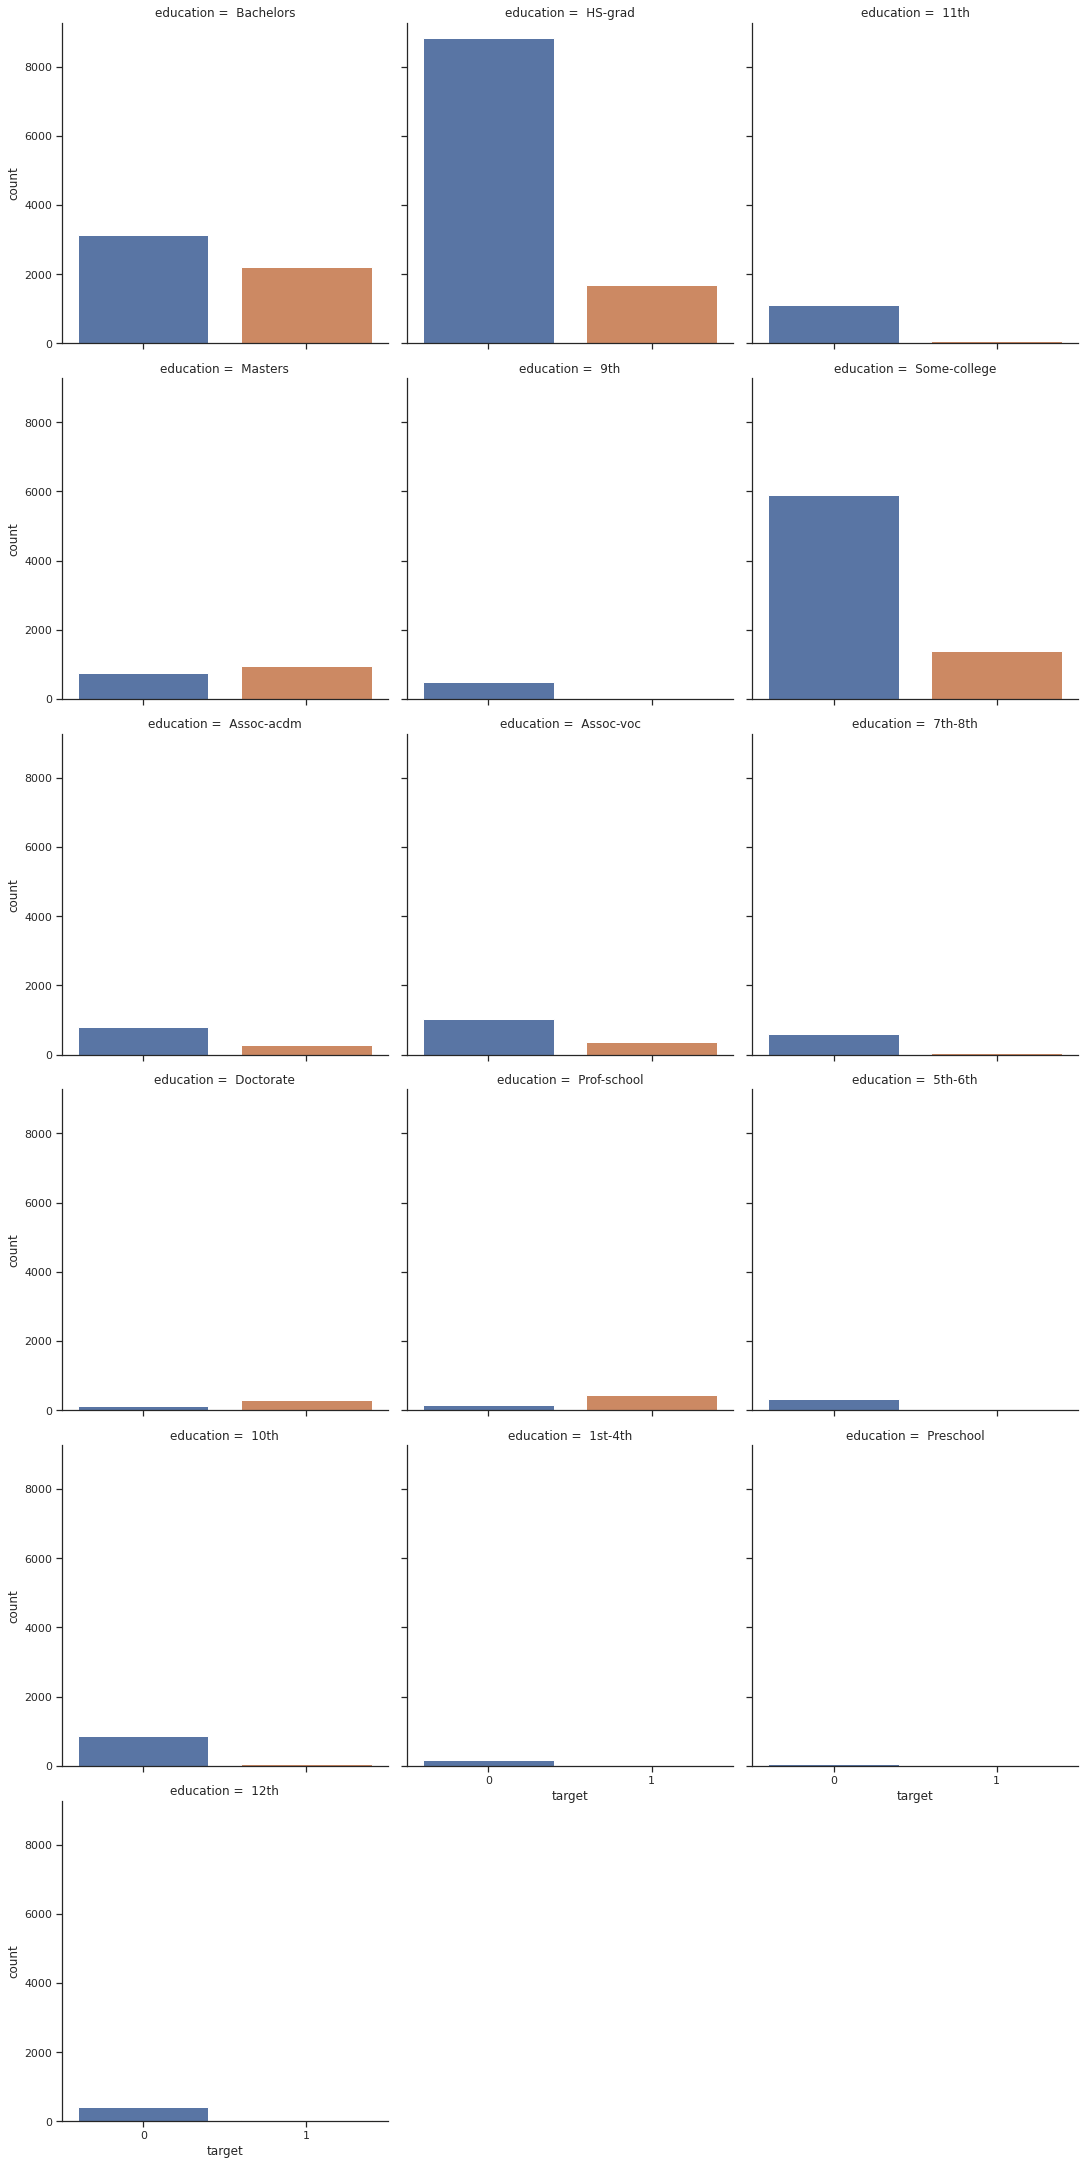

In [231]:
sns.catplot(x='target', col='education',
           data=train_eda, kind='count', col_wrap=3)

In [232]:
pd.crosstab(train_eda['target'], train_eda['education'], normalize='columns')

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
target,,,,,,,,,,,,,,,,
0,0.933548,0.948936,0.923788,0.964286,0.951952,0.93808,0.947471,0.75164,0.738784,0.585247,0.25908,0.840491,0.443413,1.0,0.265625,0.809765
1,0.066452,0.051064,0.076212,0.035714,0.048048,0.06192,0.052529,0.24836,0.261216,0.414753,0.74092,0.159509,0.556587,0.0,0.734375,0.190235


In [233]:
train_eda['education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [234]:
educ_list = [' 11th', ' 9th', ' 7th-8th', ' 5th-6th', ' 10th', 
             ' 1st-4th', ' 12th'] 
    
train_eda['education'] = train_eda['education'].apply(lambda x: 'Precollege' if x in educ_list else x)

In [235]:
pd.crosstab(train_eda['target'], train_eda['education'], normalize='columns')

education,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Precollege
target,,,,,,,,,,
0,0.75164,0.738784,0.585247,0.25908,0.840491,0.443413,1.0,0.265625,0.809765,0.941932
1,0.24836,0.261216,0.414753,0.74092,0.159509,0.556587,0.0,0.734375,0.190235,0.058068


Keep new education attribute

In [236]:
train_eda['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [237]:
train_eda['native-country'] = train_eda['native-country'].apply(
    lambda x: 'Abroad' if x != ' United-States' else x)

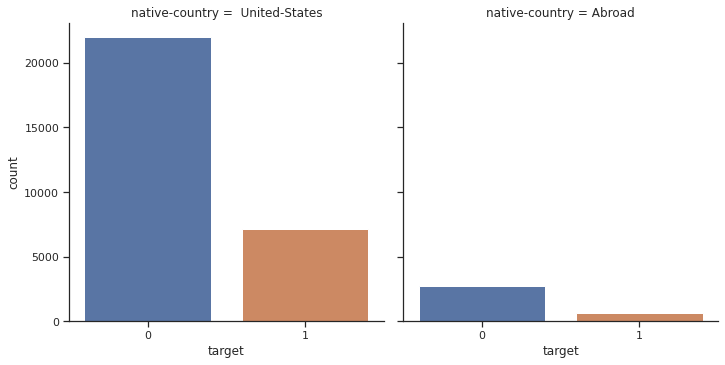

In [239]:
sns.catplot(x='target', col='native-country',
           data=train_eda, kind='count')

In [241]:
pd.crosstab(train_eda['target'], train_eda['native-country'], normalize='columns')

native-country,United-States,Abroad
target,,
0,0.754165,0.802418
1,0.245835,0.197582


drop native-country

In [243]:
train_eda['occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [246]:
pd.crosstab(train_eda['target'], train_eda['occupation'], normalize='columns')

occupation,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
target,,,,,,,,,,,,,,,
0,0.896365,0.865517,0.888889,0.773359,0.515986,0.884306,0.937226,0.875125,0.958422,0.993289,0.550966,0.674884,0.730685,0.695043,0.799624
1,0.103635,0.134483,0.111111,0.226641,0.484014,0.115694,0.062774,0.124875,0.041578,0.006711,0.449034,0.325116,0.269315,0.304957,0.200376


In [247]:
train_eda['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [248]:
list_1 = [' Exec-managerial', ' Prof-specialty']
list_2 = [' Protective-serv', ' Tech-support']
list_3 = [' Sales', ' Craft-repair', ' Transport-moving']

train_eda['occupation'] = train_eda['occupation'].apply(
    lambda x: 1 if x in list_1 else (2 if x in list_2 else (
    3 if x in list_3 else 0)))

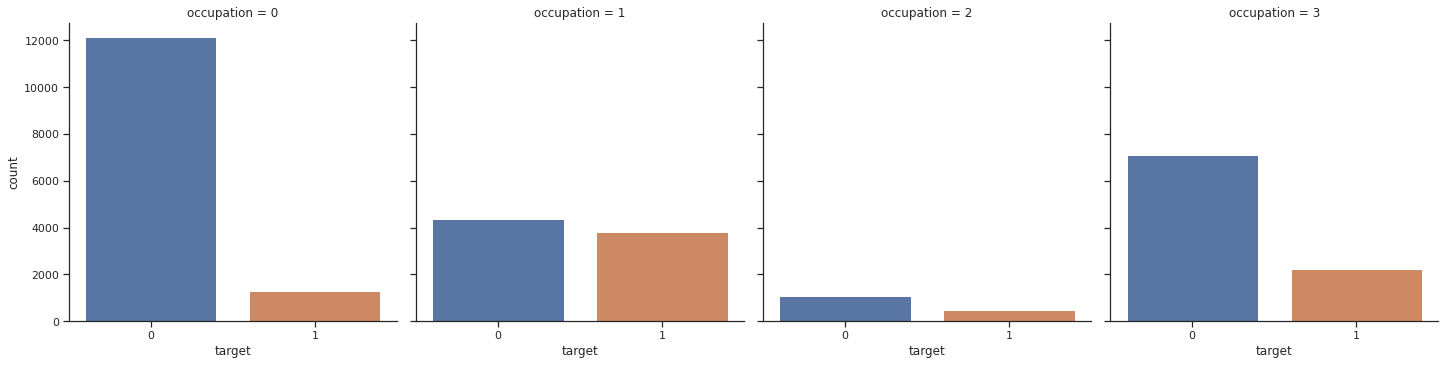

In [250]:
sns.catplot(x='target', col='occupation',
           data=train_eda, kind='count')

In [252]:
train_eda.corr()

,age,fnlwgt,education-num,occupation,capital-gain,capital-loss,hours-per-week,target,capital_var
age,1.000000,-0.076646,0.036527,0.036038,0.077674,-0.057775,0.068756,0.234037,0.074284
fnlwgt,-0.076646,1.000000,-0.043195,0.005524,0.000432,0.010252,-0.018768,-0.009463,0.000988
education-num,0.036527,-0.043195,1.000000,0.031131,0.122630,-0.079923,0.148123,0.335154,0.117891
occupation,0.036038,0.005524,0.031131,1.000000,0.016585,-0.032166,0.148712,0.116187,0.014783
capital-gain,0.077674,0.000432,0.122630,0.016585,1.000000,0.031615,0.078409,0.223329,0.998521
capital-loss,-0.057775,0.010252,-0.079923,-0.032166,0.031615,1.000000,-0.054256,-0.150526,0.085902
hours-per-week,0.068756,-0.018768,0.148123,0.148712,0.078409,-0.054256,1.000000,0.229689,0.075207
target,0.234037,-0.009463,0.335154,0.116187,0.223329,-0.150526,0.229689,1.000000,0.214428
capital_var,0.074284,0.000988,0.117891,0.014783,0.998521,0.085902,0.075207,0.214428,1.000000


In [256]:
train_eda['marital-status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [258]:
pd.crosstab(train_eda['target'], train_eda['marital-status'], normalize='columns')

marital-status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
target,,,,,,,
0,0.895791,0.565217,0.553152,0.91866,0.954039,0.93561,0.914401
1,0.104209,0.434783,0.446848,0.08134,0.045961,0.06439,0.085599


two categories Married (AF-civ)

In [301]:
train_eda['relationship'].value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

In [262]:
pd.crosstab(train_eda['target'], train_eda['relationship'], normalize='columns')

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
target,,,,,,
0,0.551429,0.89693,0.962283,0.98678,0.936738,0.524872
1,0.448571,0.10307,0.037717,0.01322,0.063262,0.475128


drop marital. maintain relationship with two categories Husband/Wife other

In [264]:
train_eda['race'].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [266]:
pd.crosstab(train_eda['target'], train_eda['race'], normalize='columns')

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
target,,,,,
0,0.884244,0.73436,0.87612,0.907749,0.74414
1,0.115756,0.26564,0.12388,0.092251,0.25586


In [267]:
pd.crosstab(train_eda['target'], train_eda['sex'], normalize='columns')

sex,Female,Male
target,,
0,0.890539,0.694263
1,0.109461,0.305737


## 4. Preparing data for ML

* Change target to boolean
* dropna row
* Change capital-loss (-)
* Change workclass
* Change education
* Drop flngt, country, marital, education-num
* two categories relationship married non-married

In [566]:
def pre_pipeline(df):
    df.dropna(axis=0, subset=['target'], inplace=True)
    X = df.drop(['target'], axis=1)
    y = df.target.copy()
    X['relationship'] = X['relationship'].apply(
        lambda x: 'Married' if x in [' Husband', ' Wife'] else 'Non-married')
    X['education'] = X['education'].apply(lambda x: 'Precollege' if x in educ_list else x)
    X['occupation'] = X['occupation'].apply(
    lambda x: 1 if x in list_1 else (2 if x in list_2 else (
    3 if x in list_3 else 0))) 
    return X, y

In [567]:
X, y = pre_pipeline(train)

In [568]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  int64 
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
dtypes: int64(7), object(7)
memory usage: 3.7+ MB


In [570]:
y

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
32556     <=50K
32557      >50K
32558     <=50K
32559     <=50K
32560      >50K
Name: target, Length: 32561, dtype: object

In [561]:
class NumAtt_transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:, 5] = X[:, 5] * -1
        X = np.delete(X, [1, 2], axis=1)
        return X 

In [562]:
class CatAtt_transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = np.delete(X, [2, 6], axis=1)
        return X

In [563]:
pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('num_transf', NumAtt_transform()),
    ('scaler', MinMaxScaler())
])

pipe_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_transf', CatAtt_transform()),
    ('encoding', OneHotEncoder())
])

In [564]:
full_pipe = ColumnTransformer([
    ('num', pipe_num, num_att),
    ('cat', pipe_cat, cat_att)
])

In [581]:
label_encode = LabelBinarizer()
y = label_encode.fit_transform(y)

In [573]:
X = cat_transform(X)
# numerical
num_att = list(X.loc[:,list(X.dtypes != 'object')].columns)
# categorical
cat_att = list(X.loc[:,list(X.dtypes == 'object')].columns)
# Pipeline
X = full_pipe.fit_transform(X)

## 5. Selecting and Training Models
* RidgeClassifier
* SGDClassifier
* BernoulliNB
* Logistic Regression
* SVC
* Random Forest
* Kneighbors

In [604]:
rdg_model = RidgeClassifier()
sgdc_model = SGDClassifier()
logit_model = LogisticRegression(solver='liblinear')
bnb_model = BernoulliNB()
svc_model = SVC()
rflorest_model = RandomForestClassifier()
kn_model = KNeighborsClassifier()

models = [rdg_model, sgdc_model, logit_model, bnb_model, svc_model, rflorest_model, kn_model]

for model in models:
    model.fit(X, np.ravel(y))

In [605]:
predictions = []
for model in models:
    predictions.append(model.predict(X))

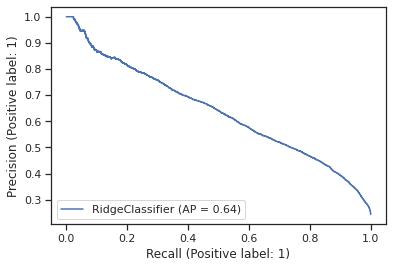

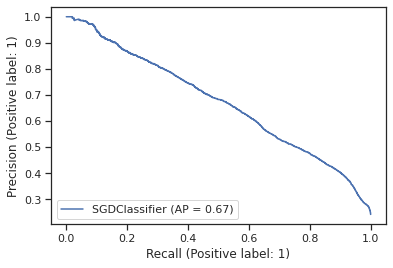

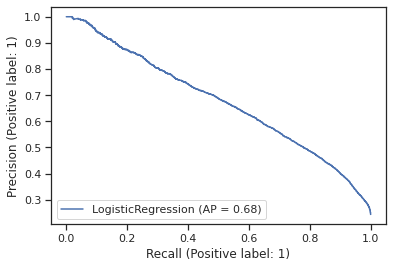

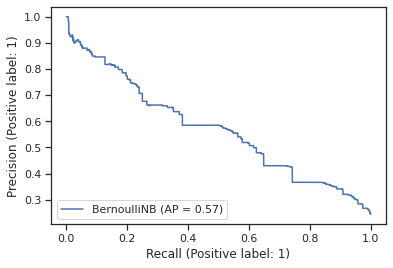

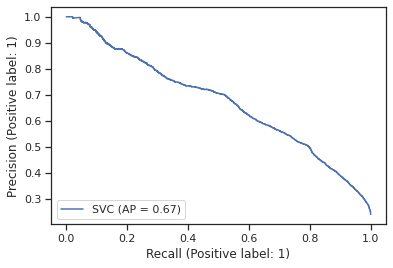

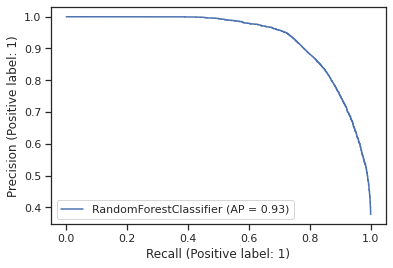

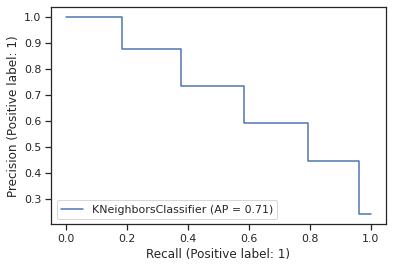

In [606]:
for model in models:
    plot_precision_recall_curve(model, X, np.ravel(y))

In [611]:
for predic in predictions:
    print(confusion_matrix(y, predic))

[[23706  1014]
 [ 5157  2684]]
[[23523  1197]
 [ 4543  3298]]
[[23410  1310]
 [ 4442  3399]]
[[21674  3046]
 [ 3740  4101]]
[[23657  1063]
 [ 4821  3020]]
[[24101   619]
 [ 1778  6063]]
[[23067  1653]
 [ 3270  4571]]
